# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
PATH = "./data/"

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [4]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [5]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [6]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [7]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [10]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

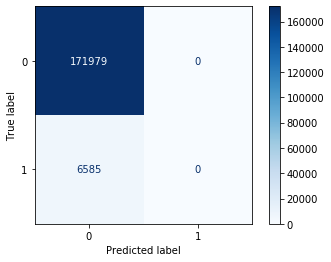

In [11]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [12]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

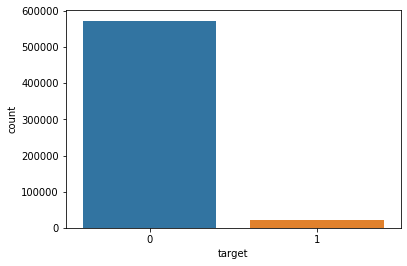

In [13]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [14]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

It's interresting, because all papers say it like a definition, that gini can be find as 2 * AUC - 1.
And that Gini coefficien sometimes used as an alternative measure. This is most commonly defined as twice the
area between the ROC curve and the diagonal (with this area being taken as negative in
the rare event that the curve lies below the diagonal). 
Let's try to see it using geometry. Image not mine, just for illustration.

Gini is the ratio of the area between our curve and the diagonal and the area between the perfect model and the diagonal.<br> 
gini = A/(A + B)<br>
<img src="gini.png" width="600">

Let's use it on the ROC curve and get the relation to the AUC.
The perfect model in the ROC is a straight diagonal line, 0% False Positive Rate and 100% True Positive Rate (purple dotted line on the image).<br>
Here A + B it's 1/2 then <br>
gini = A/(A + B) = 2 A <br>
AUC = A + 1/2 (using our image) <br>
Then  <br>
gini = 2 (AUC - 1/2) = 2AUC - 1
<img src="gini_auc.png" width="600">

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

It can be other metrics that can measure inequality, for example Generalized Entropy Indexes, Atkinson Index.

Let's calculate the Normalized Gini Coefficient:

In [15]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [16]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [17]:
insurance_data.shape

(595212, 58)

In [18]:
insurance_data.head(5)

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's see the data distribution using PCA 

In [19]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['purple', 'yellow']
    markers = ['*', '+']
    plt.figure(figsize=(20,15))
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

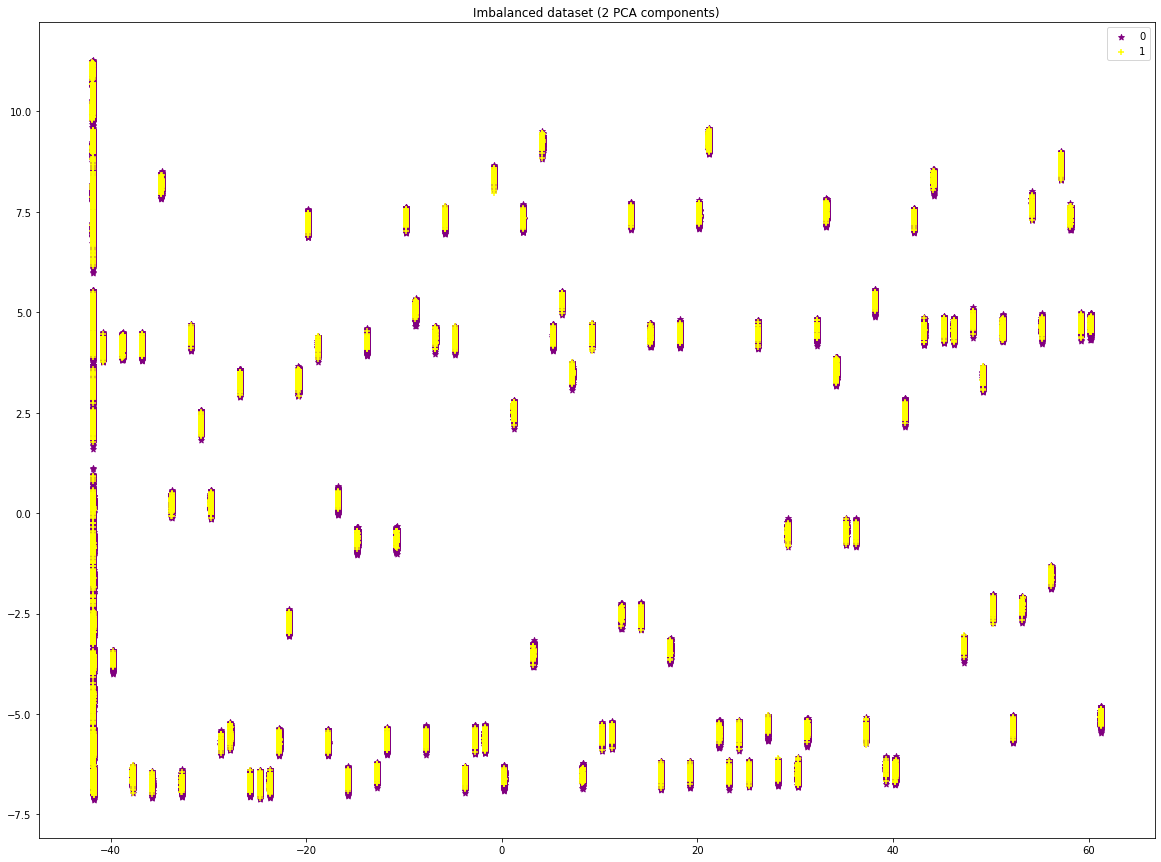

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_2d_space(X_pca, y, 'Imbalanced dataset (2 PCA components)')

In [21]:
from collections import Counter

counter = Counter(y)
print(counter)

Counter({0: 573518, 1: 21694})


In [22]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


Let's try Undersampling

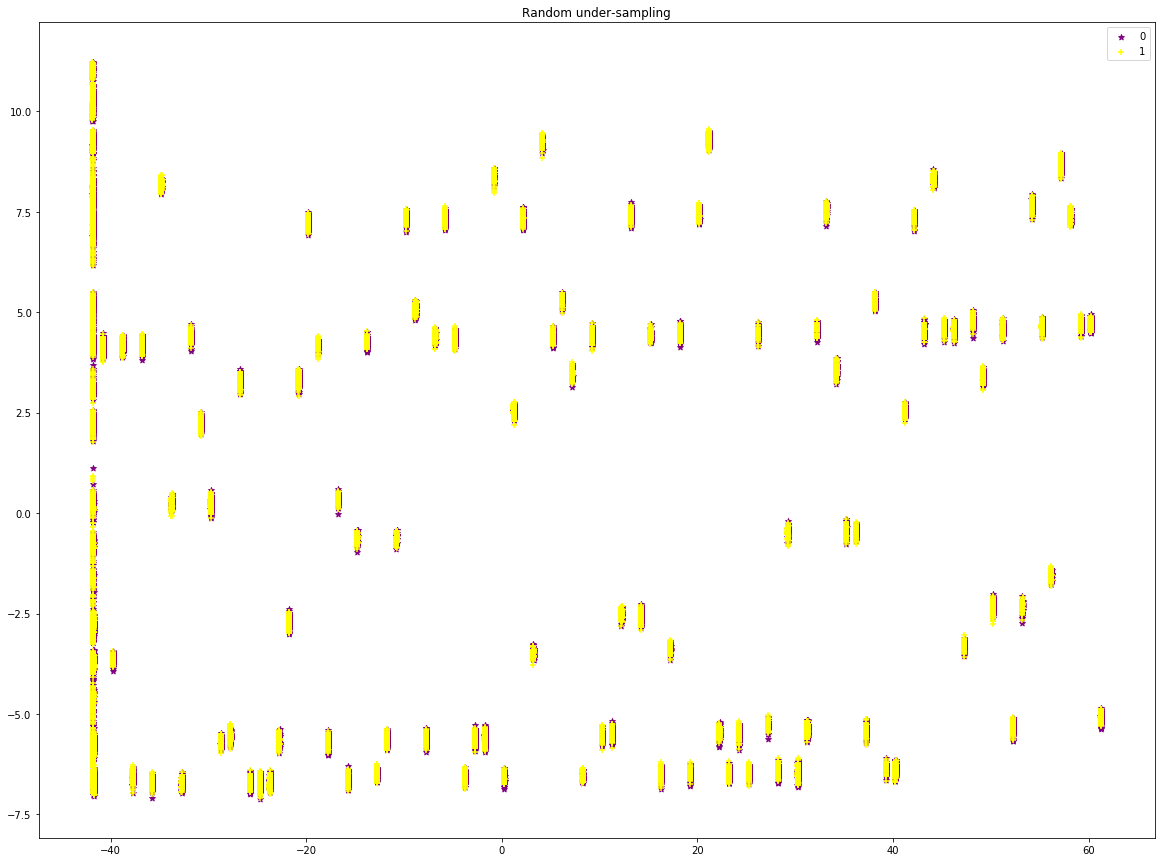

In [23]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler()
X_under, y_under = under_sampler.fit_resample(X_pca, y)
plot_2d_space(X_under, y_under, 'Random under-sampling')

In [24]:
counter = Counter(y_under)
print(counter)

Counter({0: 21694, 1: 21694})


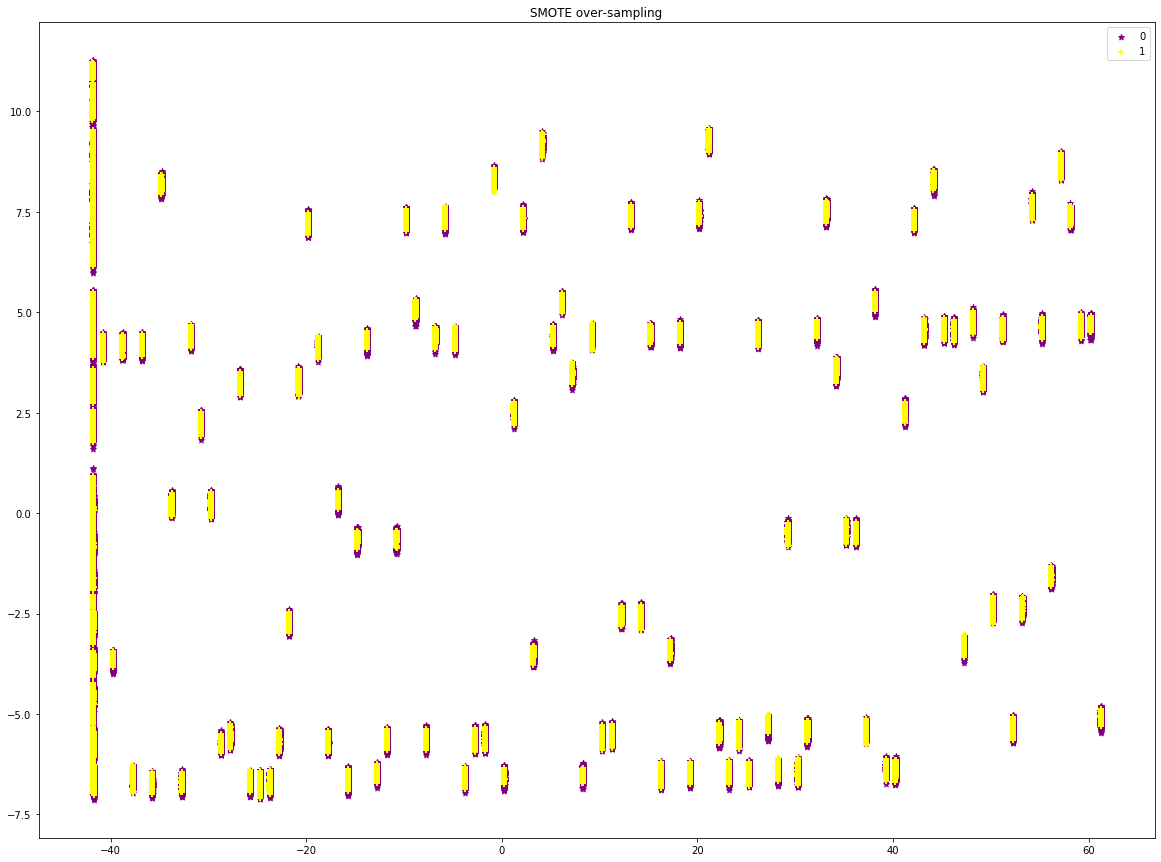

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_pca, y)
plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

In [26]:
counter = Counter(y_sm)
print(counter)

Counter({0: 573518, 1: 573518})


551824 new random picked points


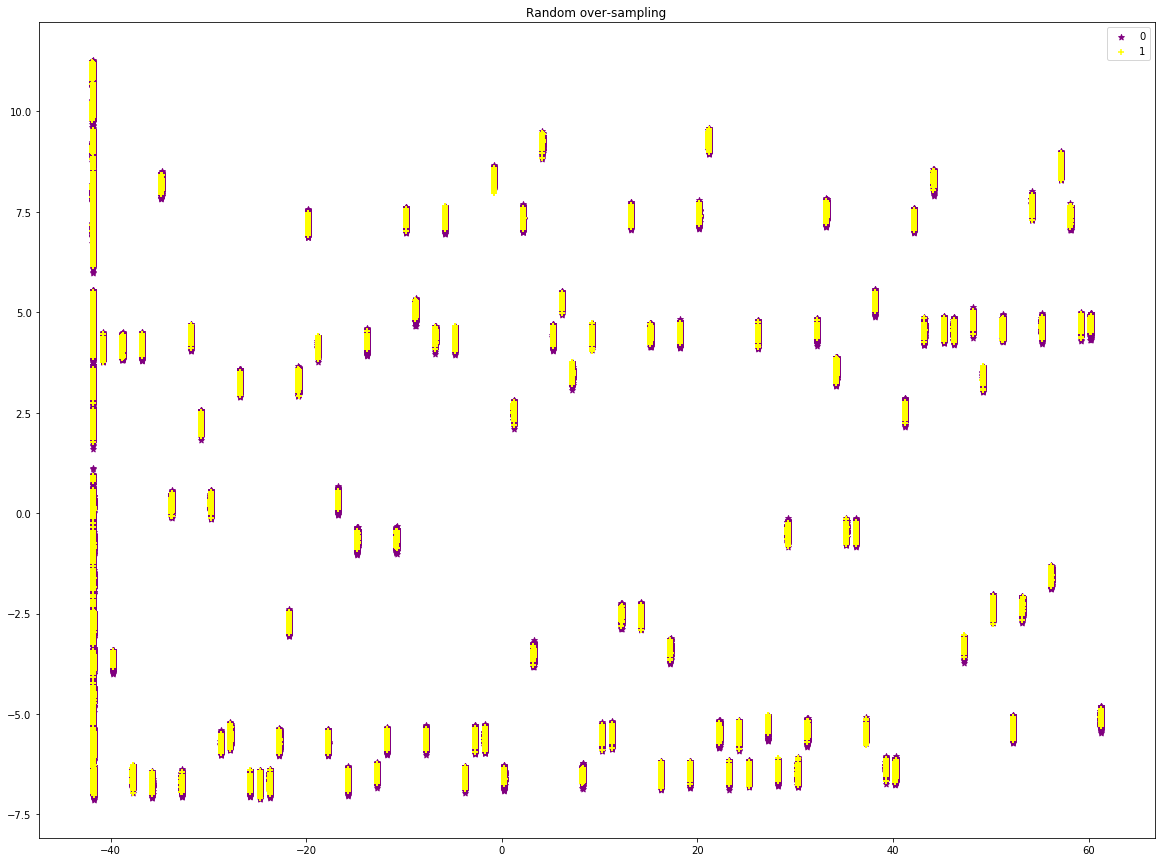

In [27]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_pca, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

MODEL

In [28]:
test = pd.read_csv(os.path.join(PATH, 'porto', 'test.csv')).set_index('id')

In [29]:
insurance_data.isnull().values.any()

False

In [30]:
test.isnull().values.any()

False

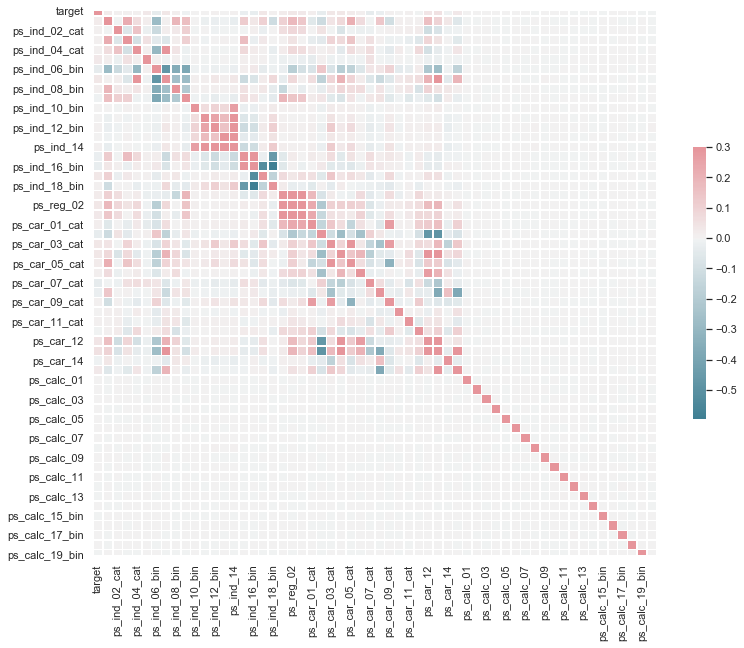

In [31]:
sns.set(style="white")

corr = insurance_data.corr()

f, ax = plt.subplots(figsize=(13, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [32]:
drop_columns = insurance_data.columns[insurance_data.columns.str.startswith('ps_calc_')]

In [33]:
train = insurance_data.drop(drop_columns, axis=1)  
test = test.drop(drop_columns, axis=1)  

In [34]:
y = train['target']
X = train.drop(columns=['target'])

In [35]:
X

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
id,,,,,,,,,,,,,,,,,,,,,
7,2,2,5,1,0,0,1,0,0,0,...,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551
9,1,1,7,0,0,0,0,1,0,0,...,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490
13,5,4,9,1,0,0,0,1,0,0,...,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625
16,0,1,2,0,0,1,0,0,0,0,...,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000
17,0,2,0,1,0,1,0,0,0,0,...,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488013,3,1,10,0,0,0,0,0,1,0,...,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751
1488016,5,1,3,0,0,0,0,0,1,0,...,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551
1488017,1,1,10,0,0,1,0,0,0,0,...,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051


In [36]:
train.nunique()

target               2
ps_ind_01            8
ps_ind_02_cat        5
ps_ind_03           12
ps_ind_04_cat        3
ps_ind_05_cat        8
ps_ind_06_bin        2
ps_ind_07_bin        2
ps_ind_08_bin        2
ps_ind_09_bin        2
ps_ind_10_bin        2
ps_ind_11_bin        2
ps_ind_12_bin        2
ps_ind_13_bin        2
ps_ind_14            5
ps_ind_15           14
ps_ind_16_bin        2
ps_ind_17_bin        2
ps_ind_18_bin        2
ps_reg_01           10
ps_reg_02           19
ps_reg_03         5013
ps_car_01_cat       13
ps_car_02_cat        3
ps_car_03_cat        3
ps_car_04_cat       10
ps_car_05_cat        3
ps_car_06_cat       18
ps_car_07_cat        3
ps_car_08_cat        2
ps_car_09_cat        6
ps_car_10_cat        3
ps_car_11_cat      104
ps_car_11            5
ps_car_12          184
ps_car_13        70482
ps_car_14          850
ps_car_15           15
dtype: int64

In [37]:
numeric_features = [column for column in train if not (column.endswith("cat") or column.endswith("bin") or column == 'target')]
categorical_features = [column for column in train if (column.endswith("cat") or column.endswith("bin"))]

In [38]:
numeric_features

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15']

In [39]:
def outlier(df, columns):
    for i in columns:
        quartile_1,quartile_3 = np.percentile(df[i],[25,75])
        quartile_f,quartile_l = np.percentile(df[i],[1,99])
        IQR = quartile_3-quartile_1
        lower_bound = quartile_1 - (1.5*IQR)
        upper_bound = quartile_3 + (1.5*IQR)
        print(i,lower_bound,upper_bound,quartile_f,quartile_l)
                
        df[i].loc[df[i] < lower_bound] = quartile_f
        df[i].loc[df[i] > upper_bound] = quartile_l
        
outlier(train, numeric_features)
outlier(test, numeric_features) 

ps_ind_01 -4.5 7.5 0.0 7.0
ps_ind_03 -4.0 12.0 0.0 11.0


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


ps_ind_14 0.0 0.0 0.0 1.0
ps_ind_15 -2.5 17.5 0.0 13.0
ps_reg_01 -0.35 1.65 0.0 0.9
ps_reg_02 -0.39999999999999997 1.2 0.0 1.7
ps_reg_03 -0.1874999999999999 1.7125 -1.0 1.8521946442
ps_car_11 0.5 4.5 0.0 3.0
ps_car_12 0.19056941500000002 0.525658351 0.3155946768 0.5656854249000001
ps_car_13 0.31788087655 1.2591761161500001 0.44830050977400004 1.6176168955090011
ps_car_14 0.23818973449999983 0.49146144250000023 -1.0 0.5234500931
ps_car_15 1.6627408985000005 4.7712375017 0.0 3.7416573868
ps_ind_01 -4.5 7.5 0.0 7.0
ps_ind_03 -4.0 12.0 0.0 11.0
ps_ind_14 0.0 0.0 0.0 1.0
ps_ind_15 -2.5 17.5 0.0 13.0
ps_reg_01 -0.35 1.65 0.0 0.9
ps_reg_02 -0.39999999999999997 1.2 0.0 1.7
ps_reg_03 -0.19226660865000011 1.7188561453500002 -1.0 1.8521946442
ps_car_11 0.5 4.5 0.0 3.0
ps_car_12 0.19056941500000002 0.525658351 0.3155946768 0.5656854249000001
ps_car_13 0.3188870638624999 1.2584782365625 0.4485283558 1.6172399231399996
ps_car_14 0.24006356474999985 0.49033714435000025 -1.0 0.5234500931
ps_car_15 1.6

In [40]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(train[numeric_features])

StandardScaler()

In [41]:
def OHE(df1,df2,column):
    cat_col = column
    #cat_col = df.select_dtypes(include =['category']).columns
    len_df1 = df1.shape[0]
    
    df = pd.concat([df1,df2],ignore_index=True)
    c2,c3 = [],{}
    
    print('Categorical feature',len(column))
    for c in cat_col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df, prefix=c3, columns=c2,drop_first=True)

    df1 = df.loc[:len_df1-1]
    df2 = df.loc[len_df1:]
    print('Train',df1.shape)
    print('Test',df2.shape)
    return df1,df2

In [42]:
train1, test1 = OHE(train, test, categorical_features)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Categorical feature 25
Train (595212, 194)
Test (892816, 194)


,ps_car_08_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,...,ohe_ps_car_11_cat_95,ohe_ps_car_11_cat_96,ohe_ps_car_11_cat_97,ohe_ps_car_11_cat_98,ohe_ps_car_11_cat_99,ohe_ps_car_11_cat_100,ohe_ps_car_11_cat_101,ohe_ps_car_11_cat_102,ohe_ps_car_11_cat_103,ohe_ps_car_11_cat_104
595212,1,1.0,0.316228,0.669556,0.352136,3.464102,0.0,8.0,0,1,...,0,0,0,0,0,0,0,0,0,0
595213,1,1.0,0.316228,0.606320,0.358329,2.828427,4.0,5.0,0,0,...,0,0,0,0,0,0,0,0,1,0
595214,1,3.0,0.400000,0.896239,0.398497,3.316625,5.0,3.0,0,0,...,0,0,0,0,0,0,0,0,0,0
595215,1,2.0,0.374166,0.652110,0.381445,2.449490,0.0,6.0,1,0,...,0,0,0,0,0,0,0,0,0,0
595216,1,3.0,0.374166,0.812914,0.385097,3.316625,5.0,7.0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488023,1,2.0,0.565685,1.617240,0.523450,3.605551,0.0,6.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1488024,0,2.0,0.424264,1.040567,0.418569,3.741657,5.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1488025,0,2.0,0.374166,0.968992,0.390384,3.741657,0.0,5.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1488026,1,3.0,0.387298,0.725125,0.378153,2.645751,6.0,5.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
X = train1.drop(['target'], axis=1)
y = train1['target'].astype('category')
x_test = test1.drop(['target'], axis=1)

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [49]:
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
pred_test_full=0
cv_score=[]
i=1
for train_index,test_index in kf.split(X,y):    
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    lr = LogisticRegression(class_weight='balanced',C=0.003)
    lr.fit(xtr, ytr)
    pred_test = lr.predict_proba(xvl)[:,1]
    score = roc_auc_score(yvl,pred_test)
    print('roc_auc_score',score)
    cv_score.append(score)
    pred_test_full += lr.predict_proba(x_test)[:,1]
    i+=1


1 of kfold 5


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


roc_auc_score 0.6339796646761905

2 of kfold 5


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


roc_auc_score 0.6292925259877495

3 of kfold 5


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


roc_auc_score 0.6309310476675194

4 of kfold 5


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


roc_auc_score 0.6332726066767338

5 of kfold 5


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


roc_auc_score 0.6249125267286235


In [50]:
print('Confusion matrix\n',confusion_matrix(yvl,lr.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Confusion matrix
 [[72334 42369]
 [ 1989  2350]]
Cv [0.6339796646761905, 0.6292925259877495, 0.6309310476675194, 0.6332726066767338, 0.6249125267286235] 
Mean cv Score 0.6304776743473633


Text(0.5, 0, 'False positive rate')

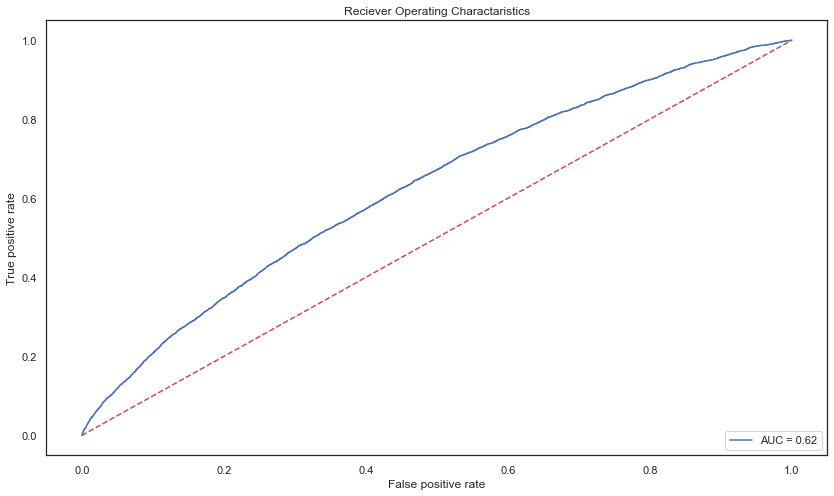

In [51]:
proba = lr.predict_proba(xvl)[:,1]
fpr,tpr, threshold = roc_curve(yvl,proba)
auc_val = auc(fpr,tpr)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % auc_val)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [52]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

In [60]:
y_pred = pred_test_full/5
submit = pd.DataFrame({'id':test.index,'target':y_pred})
submit.to_csv('my_submission_porto.csv',index=False) 

SCORE ON KAGGLE: 0.25982
    
<img src="kaggle.png" width="600">

In [64]:
score = 0.25982
Y = round(200 * max(score - 0.253, 0))/2
Y

0.5